In [1]:
import boto3
import json
import pandas as pd
print('Running boto3 version:', boto3.__version__)

Running boto3 version: 1.34.140


In [2]:
import boto3
import os
# os.environ["AWS_DEFAULT_REGION"] = "eu-west-3"
# os.environ["AWS_STS_REGIONAL_ENDPOINTS"] = "regional"

# Configuration

In [3]:
boto3_session = boto3.session.Session()
bedrock = boto3.client(service_name='bedrock-runtime')

# Variables

In [4]:
model_id = "meta.llama3-70b-instruct-v1:0"

In [5]:
def get_text_and_masked_carmen(name):
    filename = f'./data/processed/txt/{name}'
    filename_result = f'./data/processed/masked/{name}'
    with open(filename, 'r') as archivo:
        text = archivo.read()

    with open(filename_result, 'r') as archivo:
        text_masked = archivo.read()

    return [text, text_masked]

In [6]:
def generate_prompt(text, init_configuration, orden, max_gen_len=2048, temperature=0.1, top_p=0.9):
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    {init_configuration}
    <|eot_id|>
    <|start_header_id|>user<|end_header_id|>
    {orden}
    {text}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    body = json.dumps({
        "prompt": prompt,
        "max_gen_len":max_gen_len,
        "temperature":temperature,
        "top_p":top_p
    })
    return body

# Metricas

## Procesado

In [ ]:
import re
import warnings
import spacy

warnings.filterwarnings("ignore", message="\[W008\] Evaluating Doc.similarity based on empty vectors")
# Cargar el modelo de lenguaje en español mediano

nlp = spacy.load("es_core_news_md")
# Función de similitud de embeddings
def embedding_similarity(str1, str2, threshold=0.8):
    doc1 = nlp(str1)
    doc2 = nlp(str2)
    return doc1.similarity(doc2)

def eliminar_adverbios_preposiciones_determinantes(texto):
    doc = nlp(texto)
    # Eliminar preposiciones (ADP) y determinantes (DET)
    tokens_filtrados = [token.text for token in doc if token.pos_ not in ('ADP', 'DET')]
    return ' '.join(tokens_filtrados)

## Cosine similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_cos_sim(text_hoped, text_generated):
    vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w[\w\-/]*\b")
    tfidf_matrix = vectorizer.fit_transform([text_hoped, text_generated])

    try:
        cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    except: 
        return 0.0
    return cosine_sim[0][0]

## Precision and Recall

In [7]:
import numpy as np 

def calc_metrics(ground_truth, predictions):
    # Convertir arrays de ground_truth y predictions a listas de str
    ground_truth_processed = np.array([eliminar_adverbios_preposiciones_determinantes(str(item)) for item in ground_truth])
    predictions_processed = np.array([eliminar_adverbios_preposiciones_determinantes(str(item)) for item in predictions])

    # Crear matrices de similitud de coseno y embedding 
    get_cos_sim_vectorized = np.vectorize(lambda gt, pred: get_cos_sim(str(gt), str(pred)))
    embedding_similarity_vectorized = np.vectorize(lambda gt, pred: embedding_similarity(str(gt), str(pred)))

    cosine_results = get_cos_sim_vectorized(ground_truth_processed[:, None], predictions_processed[None, :])
    embedding_results = embedding_similarity_vectorized(ground_truth_processed[:, None], predictions_processed[None, :])

    # Promediar las similitudes
    avg_similarities = (cosine_results + embedding_results) / 2

    # Determinar verdaderos positivos
    matches = avg_similarities > 0.5
    true_positives = np.sum(np.any(matches, axis=1))

    # Determinar falsos negativos
    false_negatives = len(ground_truth) - true_positives

    # Determinar falsos positivos
    predicted_matches = np.any(matches, axis=0)
    false_positives = len(predictions) - np.sum(predicted_matches)

    # Cálculo de métricas
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

def evaluate(masked, generated):
    """ 
    Input: 
        - masked (str): Ground_truth text
        - generated(str): Text to be evaluated

    Output:
        - Precision, Recall and F1 (float)
    """
    ground_truth = re.findall(r'\[\*\*(.*?)\*\*\]', masked)
    predictions = re.findall(r'\[\*\*(.*?)\*\*\]', generated)
    labels = [ground_truth, predictions]
    
    return [calc_metrics(ground_truth, predictions), labels]

## Levenshtein Distance

In [9]:
from tqdm import tqdm

def levenshtein_distance(s1, s2, show_progress=True):
    """
    Calcula la distancia de Levenshtein entre dos cadenas.

    La distancia de Levenshtein es el número mínimo de operaciones de edición 
    (inserción, eliminación o sustitución de un carácter) necesarias para 
    transformar una cadena en otra.

    Parámetros:
        s1 (str): Primera cadena
        s2 (str): Segunda cadena
        show_progress (bool): Si es True, muestra una barra de progreso. 
                              Por defecto es False.
    Retorna:
        int: La distancia de Levenshtein entre s1 y s2
    """
    # Usar tqdm solo si show_progress es True
    iterable = tqdm(s1) if show_progress else s1

    if len(s1) < len(s2):
        s1, s2 = s2, s1
    if len(s2) == 0:
        return len(s1)

    previous_row = list(range(len(s2) + 1))
    for i, c1 in enumerate(iterable):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]



# Loop

In [12]:
import os
init_configuration = """You are an anonimization tool in identifying attributes in texts that can identify or quasi-identify a user."""
orden = """ Devuelve solo el texto original con la identificación y etiquetación del texto con la información personal del paciente añadiendolo entre claudators, por ejemplo: [**arquitecto**], [**8/9/21**], [**padre**]. No comentes nada más """
path = './data/processed/txt'
list_data  = []
counter = 0
for filename in os.listdir(path):
    metrics_data = {}
    [text, text_hoped] = get_text_and_masked_carmen(filename)
    body = generate_prompt(text, init_configuration, orden)
    response = bedrock.invoke_model(body=body, modelId=model_id)
    response = json.loads(response.get('body').read())
    text_generated = response['generation']
    [cal_met, labels] = evaluate(text_hoped, text_generated)    
    cosine_sim = get_cos_sim(text_hoped, text_generated)
    text_generated = text_generated.replace('[**', '').replace('**]', '')
    text_hoped = text_hoped.replace('[**', '').replace('**]', '')
    result = levenshtein_distance(text_generated, text_hoped[:len(text_generated)], show_progress=False)

    metrics_data["filename"] = filename
    metrics_data["precision"] = cal_met[0]
    metrics_data["recall"] = cal_met[1]
    metrics_data["f1"] = cal_met[2]
    metrics_data["cos"] = cosine_sim
    metrics_data["levenshtein"] = result
    metrics_data["labels hoped"] = labels[0]
    metrics_data["labels generated"] = labels[1]
    list_data.append(metrics_data)
    counter += 1
    print(counter)
    if counter == 100:
        break

TokenRetrievalError: Error when retrieving token from sso: Token has expired and refresh failed

In [8]:
metrics_info = pd.DataFrame(list_data)
metrics_info

NameError: name 'list_data' is not defined

In [13]:
metrics_info.to_csv('data/metrics/metrics.csv')

# Taller

In [10]:
import os
init_configuration = """You are an anonimization tool in identifying attributes in texts that can identify or quasi-identify a user."""
orden = """ Devuelve solo el texto original con la identificación y etiquetación del texto con la información personal del paciente añadiendolo entre claudators, por ejemplo: [**arquitecto**], [**8/9/21**], [**padre**]. No comentes nada más """
path = './data/processed/txt'

In [145]:
# record = []

for filename in tqdm(os.listdir(path)[0:10]):

    # metrics_data = {}

    # File load 
    [text, text_hoped] = get_text_and_masked_carmen(filename)

    # Prompt generation
    body = generate_prompt(text, init_configuration, orden)

    # Get response
    response = bedrock.invoke_model(body=body, modelId=model_id)
    response = json.loads(response.get('body').read())
    text_generated = response['generation']

    # [cal_met, labels] = evaluate(text_hoped, text_generated)

    # cosine_sim = get_cos_sim(text_hoped, text_generated)

    # text_generated = text_generated.replace('[**', '').replace('**]', '')

    # text_hoped = text_hoped.replace('[**', '').replace('**]', '')

    # result = levenshtein_distance(text_generated, text_hoped[:len(text_generated)], show_progress=False)

    # metrics_data["filename"] = filename
    # metrics_data["precision"] = cal_met[0]
    # metrics_data["recall"] = cal_met[1]
    # metrics_data["f1"] = cal_met[2]
    # metrics_data["cos"] = cosine_sim
    # metrics_data["levenshtein"] = result
    # metrics_data["labels hoped"] = labels[0]
    # metrics_data["labels generated"] = labels[1]

    # record.append(metrics_data)

100%|██████████| 10/10 [02:11<00:00, 13.11s/it]


In [15]:
n += 1

pd.DataFrame(record).iloc[n]['labels hoped']

['Técnico informático',
 'cónyuge',
 '11/3',
 '11/3',
 '5/3',
 '933780084',
 '963767731',
 '18/3',
 'cónyuge',
 '20/3',
 '11/3',
 '34',
 '24/03',
 '27/3',
 '11/3',
 '5/3',
 '27/03',
 '11/3',
 '5/3']

In [16]:
pd.DataFrame(record).iloc[n]['labels generated']

['Técnico informático',
 'cónyuge',
 '11/3',
 '11/3',
 '5/3',
 '933780084',
 '963767731',
 '18/3',
 'cónyuge',
 '20/3',
 '11/3',
 '5/3',
 '24/03',
 '27/3',
 '11/3',
 '5/3',
 '27/03',
 '11/3',
 '5/3']

In [17]:
# n+=1
pd.DataFrame(record).iloc[n]

filename                                            CARMEN-I_CC_4.txt
precision                                                    0.947368
recall                                                       0.947368
f1                                                           0.947368
cos                                                          0.996363
levenshtein                                                        35
labels hoped        [Técnico informático, cónyuge, 11/3, 11/3, 5/3...
labels generated    [Técnico informático, cónyuge, 11/3, 11/3, 5/3...
Name: 3, dtype: object

In [31]:
n

3

In [30]:
get_text_and_masked_carmen(os.listdir(path)[n])

['Primera llamada HDOM COVID-19 POSITIVO\n.\nTrabaja Técnico informático\nVive con cónyuge, que tuvo febrícula el 11/3\nAnt med: niega\nTto: -\nAlergias: niega\n.\nFecha frotis SARS-CoV-2: 11/3\nFecha inicio síntomas: 5/3 cefalea y tos\n.\n- Fiebre: - (paracetamol PRN)\n- Disnea: -\n- Tos: leve\n- Diarrea: 4/d líquida\n- Otros: cefalea moderada, astenia\n.\nPLAN: se explican medidas de aislamiento.\nTomar temperatura dos veces al día. Doy teléfonos de contacto (Teléfono HDOM, de lunes a domingo de 8h a 20h: 933780084 / fuera de este horario deberán llamar a la centralita del hospital: 963767731 y pedir que les comuniquen con el busca de infecciosas).\nControl el 18/3Control llamada HDOM COVID-19 POSITIVO\nSubjetivamente mejor, 4-5 días sin Paracetamol. Su cónyuge mejor sin fiebre ni tos.\nFiebre: no\nDisnea: no\nTos: persite, esputo claro\nDiarreas: no\nOtros: mejoría cefalea y astenia, náuseas matutinas\nPlan:\nNueva llamada 20/3Control llamada HDOM COVID-19 POSITIVO\nFecha frotis SAR

In [ ]:
# Run the following lines to install spacy and download the model
# 
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !python -m spacy download es_core_news_md


In [85]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy

# Cargando el modelo de spaCy para embeddings
nlp = spacy.load("es_core_news_md")

# Función de similitud de coseno
def cosine_similarity_str(str1, str2, threshold=0.5):
    vectorizer = CountVectorizer().fit_transform([str1, str2])
    vectors = vectorizer.toarray()
    cos_sim = cosine_similarity(vectors)[0][1]
    return cos_sim

# Función de similitud de embeddings
def embedding_similarity(str1, str2, threshold=0.8):
    doc1 = nlp(str1)
    doc2 = nlp(str2)
    return doc1.similarity(doc2)

# Pruebas con los ejemplos dados
cosine_examples = [
    ("abril", "abril de este año"),
    ("2017", "abril de este año"),
    ("1/01/2018", "accidente laboral")
]

embedding_examples = [
    ("abril", "abril de este año"),
    ("2017", "abril de este año"),
    ("1/01/2018", "accidente laboral")
]

# Calculando similitudes
cosine_results = [(str1, str2, cosine_similarity_str(str1, str2)) for str1, str2 in cosine_examples]
embedding_results = [(str1, str2, embedding_similarity(str1, str2)) for str1, str2 in embedding_examples]

cosine_results, embedding_results


([('abril', 'abril de este año', 0.5),
  ('2017', 'abril de este año', 0.0),
  ('1/01/2018', 'accidente laboral', 0.0)],
 [('abril', 'abril de este año', 0.6548194862024611),
  ('2017', 'abril de este año', 0.28315327356785386),
  ('1/01/2018', 'accidente laboral', 0.0)])

In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_cos_sim(text_hoped, text_generated):
    vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w[\w\-/]*\b")
    tfidf_matrix = vectorizer.fit_transform([text_hoped, text_generated])

    try:
        cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    except: 
        return 0.0
    return cosine_sim[0][0]

str1 = '5/3'
str2 = '5/3'
print(get_cos_sim(str1, str2))


1.0


In [136]:
n=0

<>:6: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\['
C:\Users\albyi\AppData\Local\Temp\ipykernel_18848\3658626384.py:6: SyntaxWarning: invalid escape sequence '\['
  warnings.filterwarnings("ignore", message="\[W008\] Evaluating Doc.similarity based on empty vectors")


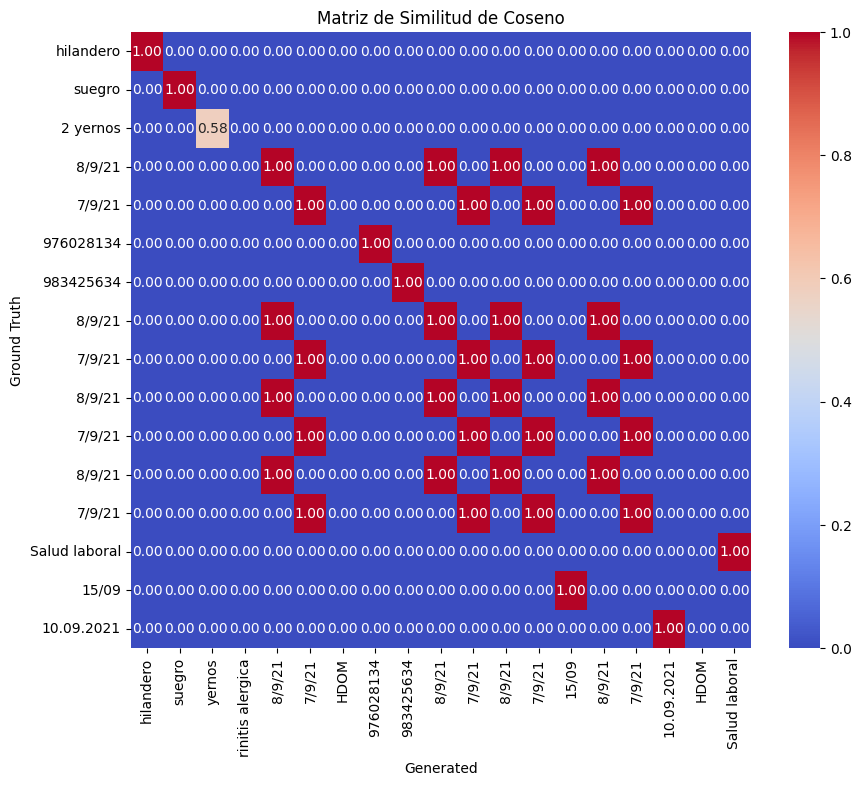

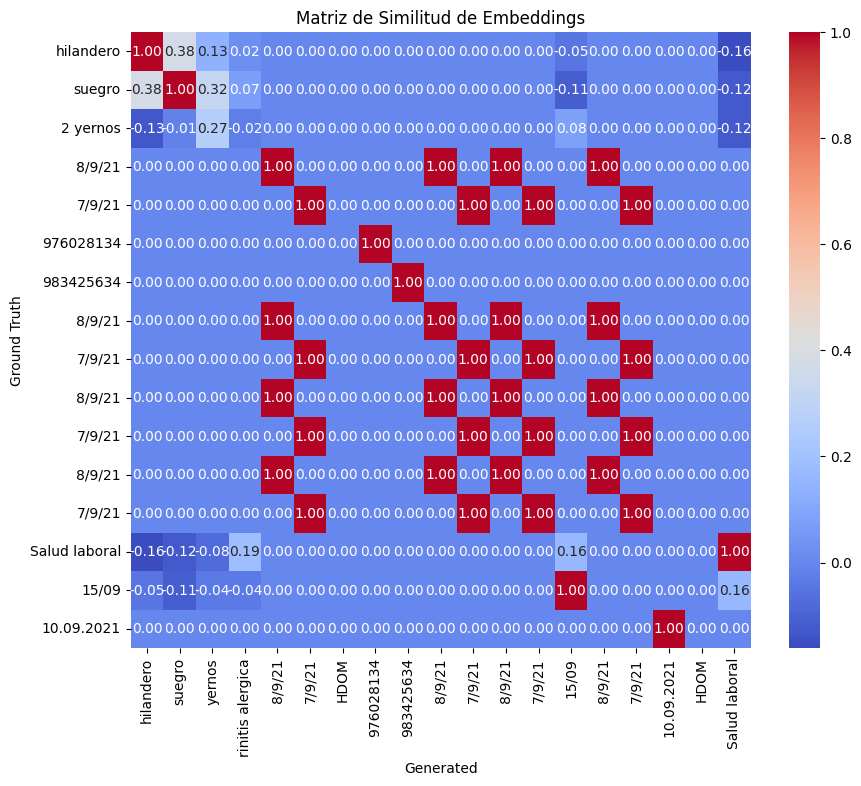

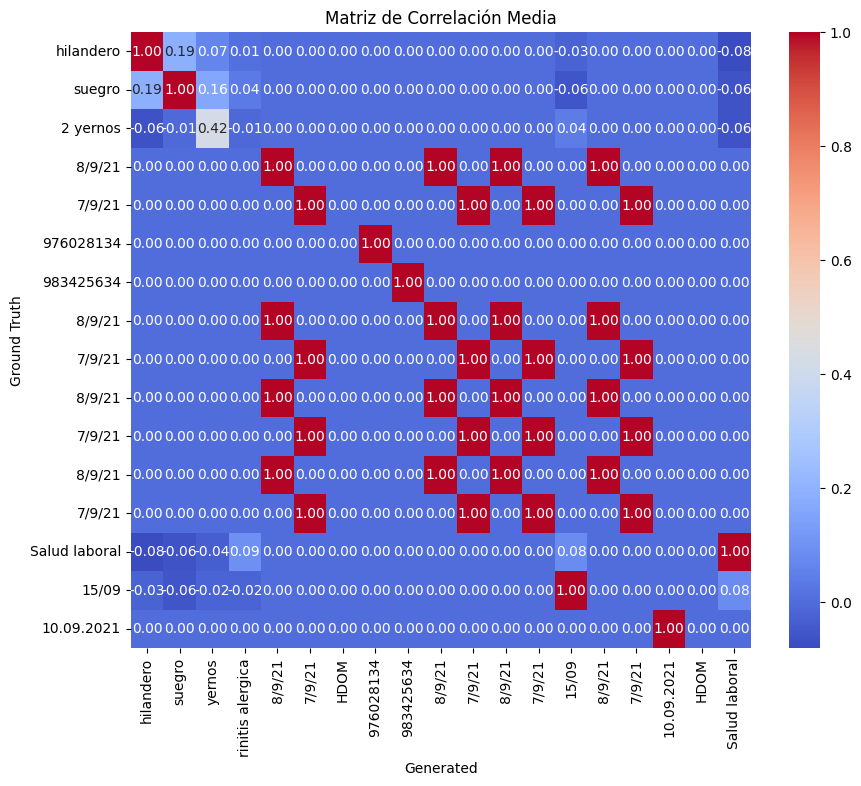

In [137]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", message="\[W008\] Evaluating Doc.similarity based on empty vectors")


ground_truth = pd.DataFrame(record).iloc[n]['labels hoped']
generated = pd.DataFrame(record).iloc[n]['labels generated']

# Calculando las métricas
cosine_results = np.zeros((len(ground_truth), len(generated)))
embedding_results = np.zeros((len(ground_truth), len(generated)))

for i, str1 in enumerate(ground_truth):
    for j, str2 in enumerate(generated):
        try:
            cosine_results[i, j] = get_cos_sim(str1, str2)
        except:
            pass
        embedding_results[i, j] = embedding_similarity(eliminar_adverbios_preposiciones_determinantes(str1), eliminar_adverbios_preposiciones_determinantes(str2))

# Creando dataframes para las matrices de correlación
cosine_df = pd.DataFrame(cosine_results, index=ground_truth, columns=generated)
embedding_df = pd.DataFrame(embedding_results, index=ground_truth, columns=generated)

# # Mostrando los resultados


# Configurando el estilo de los gráficos
# sns.set(style="whitegrid")

# Visualización de la Matriz de Similitud de Coseno
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Similitud de Coseno")
plt.xlabel("Generated")
plt.ylabel("Ground Truth")
plt.show()

# Visualización de la Matriz de Similitud de Embeddings
plt.figure(figsize=(10, 8))
sns.heatmap(embedding_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Similitud de Embeddings")
plt.xlabel("Generated")
plt.ylabel("Ground Truth")
plt.show()


# Calculando la media de las matrices de similitud
mean_matrix = (cosine_df.values + embedding_df.values) / 2

# Creando un DataFrame para la matriz de correlación media
mean_df = pd.DataFrame(mean_matrix, index=cosine_df.index, columns=cosine_df.columns)

# Visualización de la Matriz de Correlación Media
plt.figure(figsize=(10, 8))
sns.heatmap(mean_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlación Media")
plt.xlabel("Generated")
plt.ylabel("Ground Truth")
plt.show()

n += 1


In [131]:
for filename in tqdm(os.listdir(path)[0:1]):

    metrics_data = {}

    # File load 
    [text, text_hoped] = get_text_and_masked_carmen(filename)

    # Prompt generation
    body = generate_prompt(text, init_configuration, orden)

    # Get response
    response = bedrock.invoke_model(body=body, modelId=model_id)
    response = json.loads(response.get('body').read())
    text_generated = response['generation']

    print('evaluating')

    [cal_met, labels] = evaluate(text_hoped, text_generated)

  0%|          | 0/1 [00:00<?, ?it/s]

evaluating


100%|██████████| 1/1 [00:13<00:00, 13.51s/it]


In [134]:
cal_met


(0.7894736842105263, 0.9375, 0.8571428571428572)

In [62]:
get_cos_sim('abril', 'abril año')

0.5797386715376658

In [69]:
eliminar_adverbios_preposiciones('abril de este año')

'abril de este año'

In [129]:
import spacy

# Cargar el modelo de lenguaje en español mediano
nlp = spacy.load('es_core_news_md')

def eliminar_adverbios_preposiciones_determinantes(texto):
    doc = nlp(texto)
    # Eliminar preposiciones (ADP) y determinantes (DET)
    tokens_filtrados = [token.text for token in doc if token.pos_ not in ('ADP', 'DET')]
    return ' '.join(tokens_filtrados)

# Ejemplo de uso
texto = "abril de este año"
resultado = eliminar_adverbios_preposiciones_determinantes(texto)
print(resultado)


abril año


In [81]:
print(f'Sin procesar: {embedding_similarity(ground_truth[1], generated[2])}')

print(f'Sin procesar: {embedding_similarity(eliminar_adverbios_preposiciones_determinantes(ground_truth[1]), eliminar_adverbios_preposiciones_determinantes(generated[2]))}')


Sin procesar: 0.6548194862024611
Sin procesar: 0.8174622039228074


In [ ]:
str1 = 'HOSPITAL'
str2 = 'HOSPITAL del Mar'

nlp(str1).similarity(nlp(str2))

0.28644110996457933

In [ ]:
doc1 = nlp(str1)
doc2 = nlp(str2)

print([token.has_vector for token in doc1])
print([token.has_vector for token in doc2])


[True, False]
[False]


In [ ]:

embedding_similarity('20/04', '20/04')


1.0